# Análise de Dados das Eleições 

Esse notebook tem como objetivo fazer um análise e construir visualizações da dos relacionados às eleições. Para tal, serão utilizados os dados das eleições a partir do site [Base dos Dados](https://basedosdados.org). 

## Imports necessários 

Estão sendo utilizados os seguintes pacotes: 

* `basedosdados`: API do projeto Base dos Dados para acesso as base de dados e realizar consultas. 
* `pandas`: Biblioteca para manipulação das bases com python.
* `seaborn`: Biblioteca de visualização utilizando python. 

In [48]:
import pandas as pd
import basedosdados as bd
import seaborn as sns

## Sobre a análise

O objetivo é usar os dados das eleições para traçar o perfil dos candidados ao longo das últimas eleições. Para isso, serão utilizadas as seguintes tabelas:

* `basedosdados.br_tse_eleicoes.candidados`: para extrair a lista de candidados das últimas eleições. 
* `basedosdados.br_tse_eleicoes.resultados_candidatos`: para extrair informações como quantidade de votos e resultado. 
* `basedosdados.br_tse_eleicoes.bens_candidatos`: para extrair informações sobre o poder econômico. 
* `basedosdados.br_tse_eleicoes.receitas_candidatos`: para extrair informações sobre o investimento realizado nas campanhas. 

Para restringir os escopo de nossa análise vamos focar em algunas aspectos: 

* Serão analisados os dados somente do estado de Sergipe. No entanto, o código pode ser facilmente modificado para gerar análises de outros estados. 
* Vamos focar nos dados dos vereados por ter um maior número de candidados e consequentemente permitir uma melhor análise quando agruparamos esses dados. 
* As análises vão focar em enteder a distribuição dos candidados de acordo com a cor/raça, genêro e poder econômico (baseado nos bens declarados) 
* Informações de financiamento de campanha serão utilizados para entender em quais destes grupos os dados estão sendo aplicados. 


Vamos começar :) 

## Consultas

### Lista de Candidatos 


```sql
SELECT 
    b1.ano, b2.sigla_uf, b2.id_municipio, b1.tipo_eleicao, b1.id_candidato_bd, b1.nome_urna, b1.sigla_partido, 
    b1.cargo, b1.situacao, b2.resultado, b2.votos, b1.genero, b1.raca, b1.idade
FROM 
  `basedosdados.br_tse_eleicoes.candidatos` b1,
  `basedosdados.br_tse_eleicoes.resultados_candidato` b2
WHERE 
  b1.id_candidato_bd = b2.id_candidato_bd and b1.ano = b2.ano and b2.sigla_uf = 'SE' and b2.cargo = 'vereador'
ORDER BY b1.ano, b1.id_candidato_bd;
```


In [9]:
query_candidatos = """
SELECT 
    b1.ano, b2.sigla_uf, b2.id_municipio, b1.tipo_eleicao, b1.id_candidato_bd, b1.nome_urna, b1.sigla_partido, 
    b1.cargo, b1.situacao, b2.resultado, b2.votos, b1.genero, b1.raca, b1.idade
FROM 
  `basedosdados.br_tse_eleicoes.candidatos` b1,
  `basedosdados.br_tse_eleicoes.resultados_candidato` b2
WHERE 
  b1.id_candidato_bd = b2.id_candidato_bd and b1.ano = b2.ano and b2.sigla_uf = 'SE' and b2.cargo = 'vereador'
ORDER BY b1.ano, b1.id_candidato_bd;
"""

In [10]:
df_candidatos = bd.read_sql(query=query_candidatos,billing_project_id='adolfo-dev')

Downloading: 100%|██████████| 28308/28308 [00:06<00:00, 4528.92rows/s]


In [11]:
df_candidatos

,ano,sigla_uf,id_municipio,tipo_eleicao,id_candidato_bd,nome_urna,sigla_partido,cargo,situacao,resultado,votos,genero,raca,idade
0,2000,SE,2806305,eleicao ordinaria,1000073,João Donato Filho,PSDB,vereador,deferido,suplente,28,masculino,None,36.0
1,2000,SE,2804805,eleicao ordinaria,1002012,Galego Pedreiro,PGT,vereador,deferido,nao eleito,27,masculino,None,36.0
2,2000,SE,2800308,eleicao ordinaria,1002075,Ivanildo Da Silva,PTB,vereador,deferido,suplente,308,masculino,None,36.0
3,2000,SE,2807501,eleicao ordinaria,1002761,Vardo,PDT,vereador,deferido,suplente,71,masculino,None,54.0
4,2000,SE,2805604,eleicao ordinaria,1003666,Pedro Rodrigues De Souza,PSL,vereador,deferido,suplente,136,masculino,None,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28303,2020,SE,2803203,eleicao ordinaria,99864,Sandro Do Sapé,CIDADANIA,vereador,deferido,nao eleito,26,masculino,parda,37.0
28304,2020,SE,2801405,eleicao ordinaria,9991,José Calazans,PSB,vereador,deferido,nao eleito,101,masculino,parda,42.0
28305,2020,SE,2801702,eleicao ordinaria,999139,Bambam Do Povão,PT,vereador,deferido,suplente,115,feminino,parda,37.0
28306,2020,SE,2803500,eleicao ordinaria,999390,Telma Do Santo Antonio,PSD,vereador,deferido,suplente,34,feminino,parda,63.0


In [15]:
df_candidatos[['id_candidato_bd','ano','genero']].groupby(by=['ano','genero']).count()

id_candidato_bd
ano  genero                    
2000 feminino               853
     masculino             3519
2004 feminino               943
     masculino             3107
2008 feminino               816
     masculino             2884
2012 feminino              1582
     masculino             3418
2016 feminino              1680
     masculino             3426
2020 feminino              2087
     masculino             3989

In [31]:
df_query_eleitos = df_candidatos.query("resultado in ['eleito por qp','eleito','eleito por media']", engine='python')
df_query_eleitos[['id_candidato_bd','ano','genero']].groupby(by=['ano','genero']).count()

id_candidato_bd
ano  genero                    
2000 feminino               136
     masculino              661
2004 feminino               115
     masculino              578
2008 feminino               103
     masculino              592
2012 feminino               122
     masculino              673
2016 feminino               129
     masculino              672
2020 feminino               134
     masculino              670

In [27]:
df_candidatos['resultado'].value_counts().to_frame()

,resultado
suplente,19802
nao eleito,3921
eleito por qp,1908
eleito,1741
eleito por media,936


In [16]:
df_candidatos[['id_candidato_bd','ano','raca']].groupby(by=['ano','raca']).count()

id_candidato_bd
ano  raca                     
2016 amarela                46
     branca               1070
     indigena               11
     parda                3465
     preta                 514
2020 amarela                27
     branca               1147
     indigena                7
     parda                3980
     preta                 839

In [32]:
df_query_eleitos[['id_candidato_bd','ano','raca']].groupby(by=['ano','raca']).count()

id_candidato_bd
ano  raca                     
2016 amarela                11
     branca                211
     parda                 541
     preta                  38
2020 amarela                 5
     branca                160
     indigena                1
     parda                 549
     preta                  76

```sql 
SELECT b1.ano, b1.sigla_uf, b1.id_candidato_bd, b1.cargo, b1.fonte_receita, b1.origem_receita, b1.natureza_receita, b1.valor_receita, b2.genero, b2.raca FROM 
    `basedosdados.br_tse_eleicoes.receitas_candidato` b1
INNER JOIN 
    `basedosdados.br_tse_eleicoes.candidatos` b2 
ON b1.id_candidato_bd = b2.id_candidato_bd
where b1.sigla_uf = 'SE' and b1.cargo = 'vereador'
ORDER BY b1.ano
LIMIT 100;
```

In [34]:
query_receitas = """
SELECT b1.ano, b1.sigla_uf, b1.id_candidato_bd, b1.cargo, b1.fonte_receita, b1.origem_receita, b1.natureza_receita, b1.valor_receita, b2.genero, b2.raca FROM 
    `basedosdados.br_tse_eleicoes.receitas_candidato` b1
INNER JOIN 
    `basedosdados.br_tse_eleicoes.candidatos` b2 
ON b1.id_candidato_bd = b2.id_candidato_bd
where b1.sigla_uf = 'SE' and b1.cargo = 'vereador'
ORDER BY b1.ano
"""

In [36]:
df_receitas = bd.read_sql(query=query_receitas,billing_project_id='adolfo-dev')

Downloading: 100%|██████████| 108932/108932 [00:12<00:00, 8844.78rows/s]


In [37]:
df_receitas

,ano,sigla_uf,id_candidato_bd,cargo,fonte_receita,origem_receita,natureza_receita,valor_receita,genero,raca
0,2008,SE,616606,vereador,None,recursos de partido politico,None,6000.0,masculino,None
1,2008,SE,616606,vereador,None,recursos proprios,None,20.0,masculino,None
2,2008,SE,616606,vereador,None,recursos de partido politico,None,2000.0,masculino,None
3,2008,SE,616606,vereador,None,recursos de partido politico,None,1000.0,masculino,None
4,2008,SE,616606,vereador,None,recursos de partido politico,None,3100.0,masculino,None
...,...,...,...,...,...,...,...,...,...,...
108927,2020,SE,1659921,vereador,fundo especial,recursos de outros candidatos,estimavel,158.0,masculino,branca
108928,2020,SE,1659921,vereador,outros recursos,recursos proprios,financeiro,500.0,masculino,branca
108929,2020,SE,1659921,vereador,outros recursos,recursos proprios,estimavel,1140.0,masculino,branca
108930,2020,SE,1659921,vereador,outros recursos,recursos de pessoas fisicas,financeiro,1000.0,masculino,branca


In [43]:
df_receitas['origem_receita'].value_counts()

recursos de pessoas fisicas              40922
recursos de outros candidatos            26669
recursos proprios                        24349
recursos de partido politico             16680
recursos de outros candidatos/comites      152
recursos de financiamento coletivo          78
recursos de origens nao identificadas       51
recursos de pessoas juridicas               20
doacoes pela internet                       11
Name: origem_receita, dtype: int64

<AxesSubplot:title={'center':'valor_receita'}, xlabel='[genero]'>

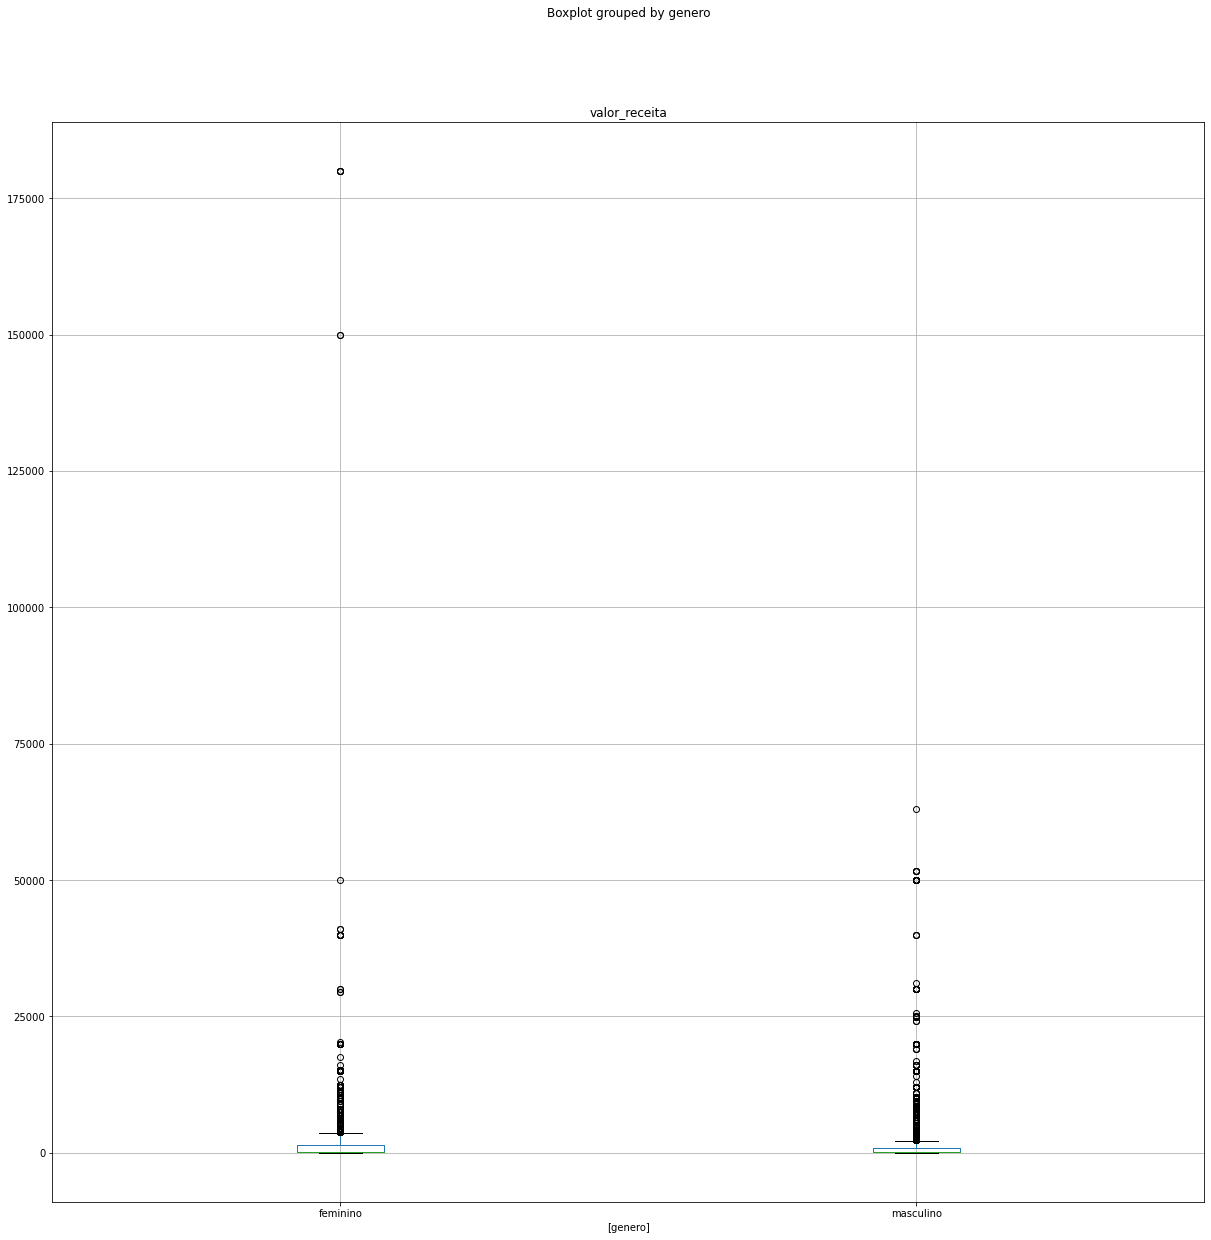

In [46]:
df_receitas[df_receitas['origem_receita'] == 'recursos de partido politico'].boxplot(column=['valor_receita'], by=['genero'], figsize=(20,20))

<AxesSubplot:xlabel='valor_receita', ylabel='genero'>

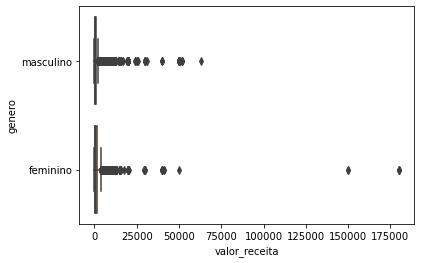

In [61]:
df_filter = df_receitas.query("origem_receita == 'recursos de partido politico'")
sns.boxplot(x=df_filter["valor_receita"], y=df_filter['genero'])

In [62]:
df_filter.query("genero == 'masculino'").describe()

,ano,valor_receita
count,12271.000000,12271.000000
mean,2018.530519,1225.325682
std,2.000129,3499.380925
min,2008.000000,0.090000
25%,2016.000000,71.430000
50%,2020.000000,165.000000
75%,2020.000000,927.000000
max,2020.000000,63000.000000


In [63]:
df_filter.query("genero == 'feminino'").describe()

,ano,valor_receita
count,4409.000000,4409.000000
mean,2019.041052,1787.894196
std,1.707885,7093.783877
min,2016.000000,0.020000
25%,2020.000000,71.430000
50%,2020.000000,198.000000
75%,2020.000000,1500.000000
max,2020.000000,180000.000000
